In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from set_axes import set_ax
from models import CompartmentManager, StochasticSRI, DeterministicSRI

The model we initially considered is the Susceptible-Infected-Recovered (SIR). A slight generalization of it is the Susceptible-Infected-Exposed-Recovered (SIER). Since there is enough information available about the incubation period of Covid-19, it might be worth implementing both in first place. 
Starting with SIR, the dynamic equations are given by:
$$
\dot{S} = -\frac{\beta}{N} SI \\
\dot{I} = \frac{\beta}{N} SI - \gamma I \\
\dot{R} = \gamma I \\
S + I + R = N
$$
Where $R_0 = \beta/\gamma$ represents the average growth rate of the virus.
For a discrete time model a forwards Euler integration should suffice. We introduce the SIR class for an easier API. The following objects can be used for the evolution of the population within a single compartment of the population.

### Deterministic Model

Created to play around with parameters

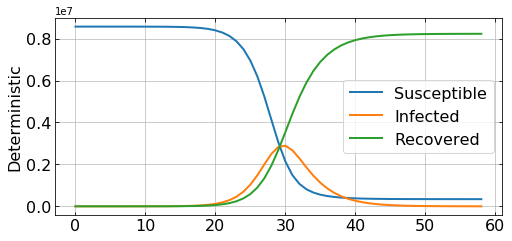

In [780]:
params = {'beta' : 0.9, 'gamma' : 0.3, 'S0' : 8570000, 'I0' : 10, 'R0' : 0}
model = DeterministicSRI(**params)
model.evolve(days=58)

xlabel = 'Days'
ylabel = 'Deterministic'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax.plot(model.time, model.S, linewidth=2, label='Susceptible')
ax.plot(model.time, model.I, linewidth=2, label='Infected')
ax.plot(model.time, model.R, linewidth=2, label='Recovered')
#ax.plot(model.time, confirmed, linewidth=2, label='Confirmed')

set_ax(ax, ylabel=ylabel, legend=True)
plt.show()

### Comparing deterministic and stochastic SRI models

In [781]:
# example use
params = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 999, 'I0' : 1, 'R0' : 0}
model1 = DeterministicSRI(**params)
model1.evolve(days=100)
model2 = StochasticSRI(**params)
model2.evolve(days=100)

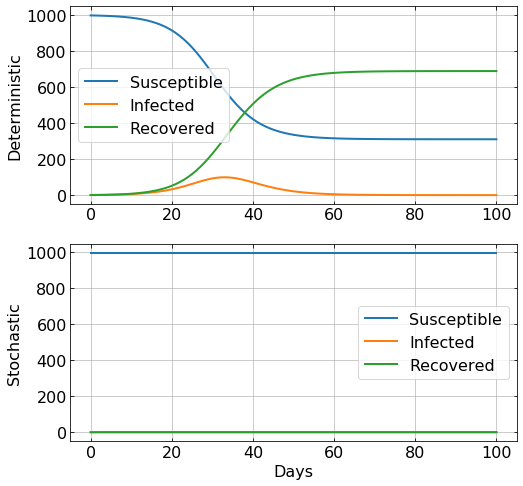

In [782]:
xlabel = 'Days'
ylabel1 = 'Deterministic'
ylabel2 = 'Stochastic'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(model1.time, model1.S, linewidth=2, label='Susceptible')
ax1.plot(model1.time, model1.I, linewidth=2, label='Infected')
ax1.plot(model1.time, model1.R, linewidth=2, label='Recovered')
ax2.plot(model2.time, model2.S, linewidth=2, label='Susceptible')
ax2.plot(model2.time, model2.I, linewidth=2, label='Infected')
ax2.plot(model2.time, model2.R, linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, xlabel=xlabel, ylabel=ylabel2, legend=True)
plt.show()

### Two deterministic cells interacting together

In [783]:
# interacting cells

params = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 999, 'I0' : 1, 'R0' : 0}
params2 = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 1000, 'I0' : 0, 'R0' : 0}
cell1 = DeterministicSRI(**params)
cell2 = DeterministicSRI(**params2)
link = 0.000001
days = 150

for i in range(days):
    cell1.integrate(other=cell2, link=link)
    cell2.integrate(other=cell1, link=link)

**Questions to answer**:
1. Determine Measure $m_1$ with which we should start
2. Does
$P(\text{child infects elderly}|\text{Measure } m_k \text{ is in place}) == P(\text{elderly infects child}|\text{Measure } m_k \text{ is in place})$
3. Determine initial variables in the context of the covid-19, i.e. $\beta, \gamma$
4. Set$ S_0, I_0, R_0 $ in function of the population under study (Switzerland or Italy)


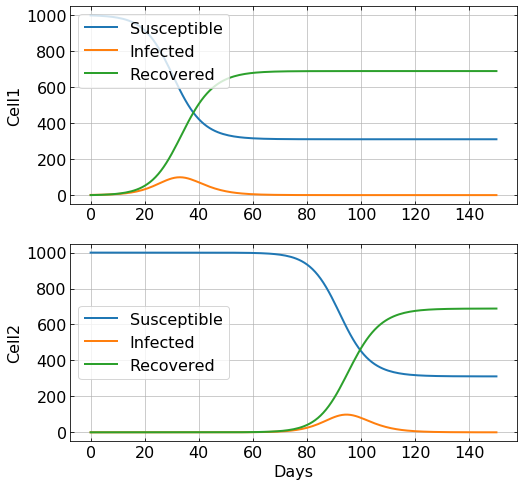

In [784]:
xlabel = 'Days'
ylabel1 = 'Cell1'
ylabel2 = 'Cell2'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(cell1.time, cell1.S, linewidth=2, label='Susceptible')
ax1.plot(cell1.time, cell1.I, linewidth=2, label='Infected')
ax1.plot(cell1.time, cell1.R, linewidth=2, label='Recovered')
ax2.plot(cell2.time, cell2.S, linewidth=2, label='Susceptible')
ax2.plot(cell2.time, cell2.I, linewidth=2, label='Infected')
ax2.plot(cell2.time, cell2.R, linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, xlabel=xlabel, ylabel=ylabel2, legend=True)
plt.show()

### Testing four interacting cells

In [6]:
link = 1e-4
params = {'beta' : 0.4, 'gamma' : 0.4, 'S0' : 99999, 'I0' : 100, 'R0' : 0}
params2 = {'beta' : 0.8, 'gamma' : 0.5, 'S0' : 1000, 'I0' : 0, 'R0' : 0}
params3 = {'beta' : 0.6, 'gamma' : 0.5, 'S0' : 1000, 'I0' : 0, 'R0' : 0}
params4 = {'beta' : 1, 'gamma' : 0.3, 'S0' : 10000000, 'I0' : 0, 'R0' : 0}
param_list=[params, params2, params3, params4]  # one cell with 10 infects and all others infection-free

simulator = CompartmentManager(parameters_list=param_list, link=link, model='stoch')
simulator.evolve(200)

Ss = simulator.S
Is = simulator.I
Rs = simulator.R

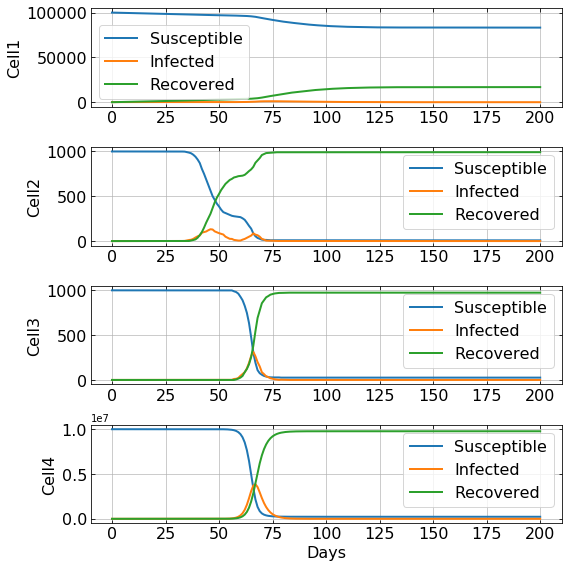

In [8]:
xlabel = 'Days'
ylabel1 = 'Cell1'
ylabel2 = 'Cell2'
ylabel3 = 'Cell3'
ylabel4 = 'Cell4'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(simulator.time, Ss[0], linewidth=2, label='Susceptible')
ax1.plot(simulator.time, Is[0], linewidth=2, label='Infected')
ax1.plot(simulator.time, Rs[0], linewidth=2, label='Recovered')
ax2.plot(simulator.time, Ss[1], linewidth=2, label='Susceptible')
ax2.plot(simulator.time, Is[1], linewidth=2, label='Infected')
ax2.plot(simulator.time, Rs[1], linewidth=2, label='Recovered')
ax3.plot(simulator.time, Ss[2], linewidth=2, label='Susceptible')
ax3.plot(simulator.time, Is[2], linewidth=2, label='Infected')
ax3.plot(simulator.time, Rs[2], linewidth=2, label='Recovered')
ax4.plot(simulator.time, Ss[3], linewidth=2, label='Susceptible')
ax4.plot(simulator.time, Is[3], linewidth=2, label='Infected')
ax4.plot(simulator.time, Rs[3], linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, ylabel=ylabel2, legend=True)
set_ax(ax3, ylabel=ylabel3, legend=True)
set_ax(ax4, xlabel=xlabel, ylabel=ylabel4, legend=True)
plt.tight_layout()
fig.savefig('four_cell_interaction.pdf')
plt.show()

## Finding optimal parameters

In [72]:
import pandas as pd
confirmed = pd.read_csv('Corona-Virus-Dataset/time_series_covid_19_confirmed.csv')

In [73]:
confirmed = list(confirmed[confirmed['Country/Region'] == 'Switzerland'].iloc[0,4:])

In [76]:
days = len(confirmed)

In [46]:
#Residual Sum of Squares
def rss(pred, true):
    """pred: array, value we predict (i.e. number of confirmed cases/number of deaths)
       true: array, actual value (i.e. real number of confirmed cases/number of deaths)"""
    return np.sum(np.square(pred-true))

In [90]:
gammas = np.arange(0.0, 0.5, 0.0001)
betas = np.arange(0, 0.3, 0.0001)

M = np.zeros((len(gammas), len(betas)))

for i, g in tqdm(enumerate(gammas)):
    for j, b in enumerate(betas):
        
        params = params = {'beta' : b, 'gamma' : g, 'S0' : 8570000, 'I0' : 10, 'R0' : 0}
        model = DeterministicSRI(**params)
        model.evolve(days=days-1)
        
        M[i,j] = rss(model.I, confirmed)
        
        


0it [00:00, ?it/s]
1it [00:00,  1.54it/s]
2it [00:01,  1.45it/s]
3it [00:01,  1.54it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.54it/s]
6it [00:03,  1.51it/s]
7it [00:04,  1.51it/s]
8it [00:05,  1.54it/s]
9it [00:05,  1.62it/s]
10it [00:06,  1.66it/s]
11it [00:06,  1.70it/s]
12it [00:07,  1.73it/s]
13it [00:07,  1.76it/s]
14it [00:08,  1.69it/s]
15it [00:09,  1.70it/s]
16it [00:09,  1.66it/s]
17it [00:10,  1.66it/s]
18it [00:11,  1.67it/s]
19it [00:11,  1.69it/s]
20it [00:12,  1.67it/s]
21it [00:12,  1.65it/s]
22it [00:13,  1.68it/s]
23it [00:14,  1.66it/s]
24it [00:14,  1.65it/s]
25it [00:15,  1.69it/s]
26it [00:15,  1.73it/s]
27it [00:16,  1.64it/s]
28it [00:17,  1.67it/s]
29it [00:17,  1.50it/s]
30it [00:18,  1.54it/s]
31it [00:19,  1.58it/s]
32it [00:19,  1.62it/s]
33it [00:20,  1.68it/s]
34it [00:20,  1.72it/s]
35it [00:21,  1.73it/s]
36it [00:21,  1.74it/s]
37it [00:22,  1.75it/s]
38it [00:22,  1.78it/s]
39it [00:23,  1.71it/s]
40it [00:24,  1.69it/s]
41it [00:24,  1.71it/s]
42it 

In [87]:
# Minimum  for gamma ranging from 0 to 0.5 every 0.01 and beta 0.3 every 0.01: np.amin(M) == 13735842.997290796
# Minimum  for gamma ranging from 0 to 0.5 every 0.001 and beta 0.3 every 0.001: np.amin(M) == 11553693.198378215
# Minimum  for gamma ranging from 0 to 0.5 every 0.0001 and beta 0.3 every 0.0001: np.amin(M) == 11519246.337220717



13735842.997290796

In [91]:
np.amin(M)

11519246.337220717